# Clustering
In this notebook we will try to apply clustering techniques to the dataset.

## Libraries    

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json

# sklearn utilities
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

## Prepare Data

In [66]:
# import data
claims_df = pd.read_csv('data/postprocessed/claims.csv')

In [67]:
# delete nans in the claims column
claims_df = claims_df.dropna(subset=['claim'])

In [68]:
# build a vector for the claims
claims_str = np.array(claims_df['claim'])
claims_str

array(['Hunter Biden had no experience in Ukraine or in the energy sector when he joined the board of Burisma.',
       'Donald Trump delivered the largest tax cuts in American history.',
       'In Nigeria … in terms of revenue share, 20% goes to the local government.',
       ...,
       'Matt Hancock owns the company responsible for supplying the NHS.',
       '£1 billion was given to 13 companies for PPE but no PPE has been supplied.',
       'Mixing one tablespoon of 2% iodine and one cup of baby oil will create a substance that removes body hair.'],
      dtype=object)

In [69]:
# split in train and test
claims_train, claims_test = train_test_split(claims_str, test_size=0.2, random_state=42)
print(f'Train size: {len(claims_train)}')
print(f'Test size: {len(claims_test)}')

Train size: 2453
Test size: 614


In [70]:
# define a vectorizer
vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)

In [135]:
# fit the vectorizer
vector_claims_train = vectorizer.fit_transform(claims_train)

  (0, 484)	1
  (0, 751)	1
  (0, 526)	1
  (0, 273)	1
  (0, 24)	1
  (0, 8)	1
  (0, 453)	1
  (0, 976)	1


In [89]:
# get the vocabulary
vocab = vectorizer.get_feature_names_out()
len(vocab)

1141

# LDA - Latent Dirichlet Allocation

In [136]:
# perplexity analysis using bagging method
def perplexity_analysis(n_topics: list, data: np.array) -> list:
    perplexity = []
    for n in n_topics:
      claims_train_LDA, claims_test_LDA = train_test_split(data, test_size=0.2, random_state=42)
      vector_train_LDA = vectorizer.fit_transform(claims_train_LDA)
      lda = LatentDirichletAllocation(n_components=n, learning_method='online', random_state=42, max_iter=15, n_jobs=5)
      lda.fit_transform(vector_train_LDA)
      vector_test_LDA = vectorizer.fit_transform(claims_test_LDA)
      p = lda.perplexity(vector_test_LDA)
      perplexity.append(p)
    
      print(f'Perplexity for {n} topics: {p}')

    # plot the results of the perplexity analysis
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(n_topics, perplexity, 'o-', color='blue', label='Perplexity')
    plt.grid(True)
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity')
    plt.xticks(n_topics)
    plt.legend()
    plt.title('LDA')
    
    return perplexity

Perplexity for 1 topics: 2620.9502206236643
Perplexity for 2 topics: 5008.09434665361
Perplexity for 3 topics: 8243.010986513887
Perplexity for 4 topics: 11487.818025866824
Perplexity for 5 topics: 14368.430847524614
Perplexity for 6 topics: 18661.019730016753
Perplexity for 7 topics: 21441.877332020715
Perplexity for 8 topics: 24019.73901323461
Perplexity for 9 topics: 26913.48428786859


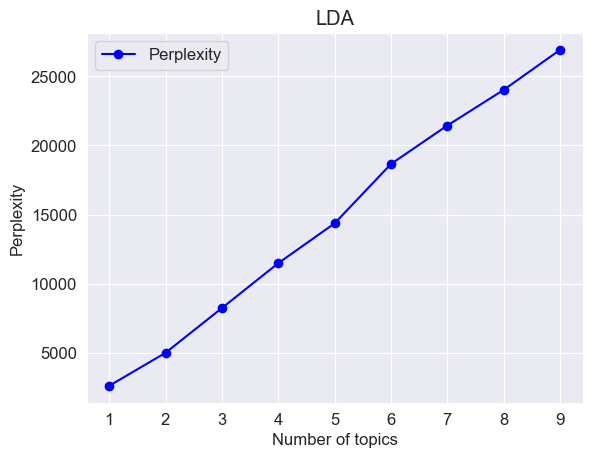

In [137]:
perplexity = perplexity_analysis(np.arange(1, 10), claims_str)

In [138]:
# retrain the model with the 3 as numer of topics
lda = LatentDirichletAllocation(n_components=4, learning_method='online', random_state=42, max_iter=15, n_jobs=5)
lda.fit_transform(vector_claims_train)

array([[0.04309485, 0.88260589, 0.03807979, 0.03621947],
       [0.02510699, 0.0274652 , 0.02521401, 0.9222138 ],
       [0.02103656, 0.02130532, 0.02178847, 0.93586965],
       ...,
       [0.20440666, 0.71221953, 0.04166889, 0.04170492],
       [0.75921826, 0.17701067, 0.03193533, 0.03183574],
       [0.56377612, 0.18926924, 0.20991152, 0.03704313]])

In [140]:
# print the topics
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)
    
"""
Topic 1: Political Statements & Events
Topic 2: Global Health Crisis
Topic 3: African Pandemic Impact
Topic 4: US Presidential Politics
"""

Topic 1:	 [president, water, years, obama, said, 2020, people, government, coronavirus, march]
Topic 2:	 [19, covid, 000, nigeria, people, million, kenya, new, years, 2019]
Topic 3:	 [south, free, africa, year, million, number, children, coronavirus, died, said]
Topic 4:	 [trump, president, donald, coronavirus, states, world, biden, united, people, said]


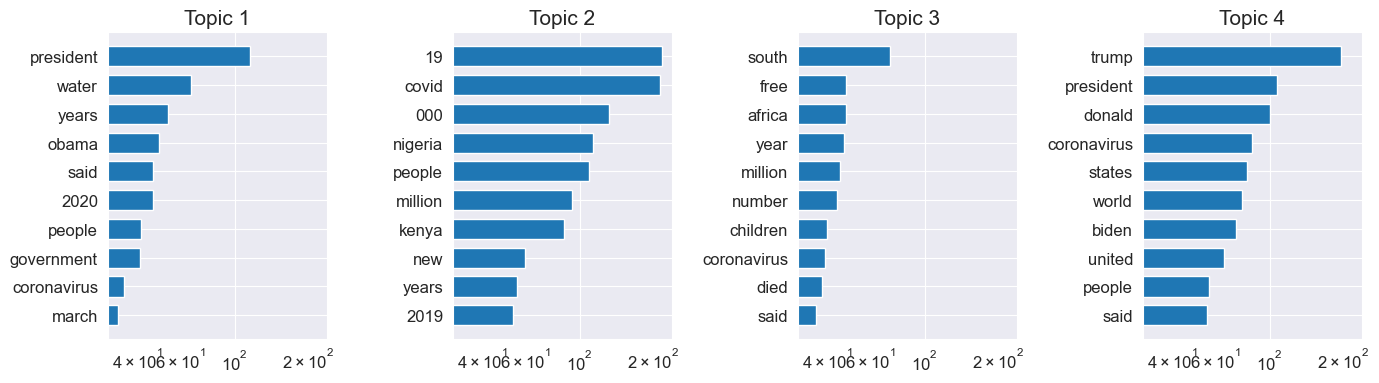

In [141]:
# plot the clusters num_words = 10
num_words = 10
cols = 4
rows = int(len(lda.components_)/4)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [142]:
# plot with t-stne
tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_claims_train))
tsne_embedding.shape

(2453, 3)

In [143]:
[x, y, z] = np.transpose(tsne_embedding)
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_claims_train)]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=freq_topic,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

## ANOVA

In [144]:
#@todo#